<a href="https://colab.research.google.com/github/tablehan/deepLearningPractice/blob/main/LSTMforCCI30_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.path.abspath('')

'/content'

In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import time

In [3]:
# 從網路直接抓cci30過來測試建模
df=pd.read_csv("https://cci30.com/ajax/getIndexHistory.php",index_col=0).iloc[::-1,:]
print(df.shape)
df.tail()

(2827, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2022-09-23,7436.16,7704.71,7154.14,7509.82,6.951557e+10
2022-09-24,7509.82,7647.16,7332.20,7386.42,4.381290e+10
2022-09-25,7386.23,7546.36,7220.37,7308.52,6.020709e+10
2022-09-26,7309.39,7472.79,7170.73,7383.25,7.613303e+10
2022-09-27,7383.37,7725.25,7190.13,7304.55,8.843916e+10


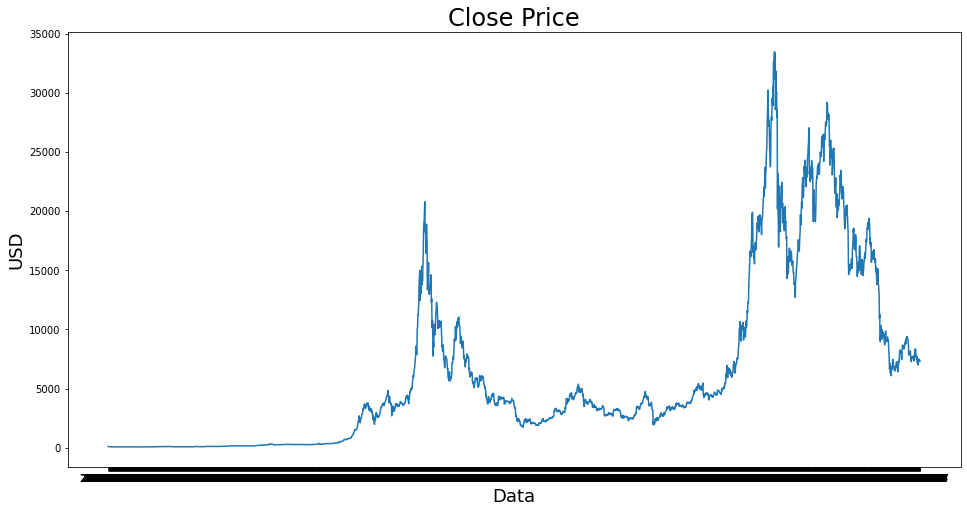

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

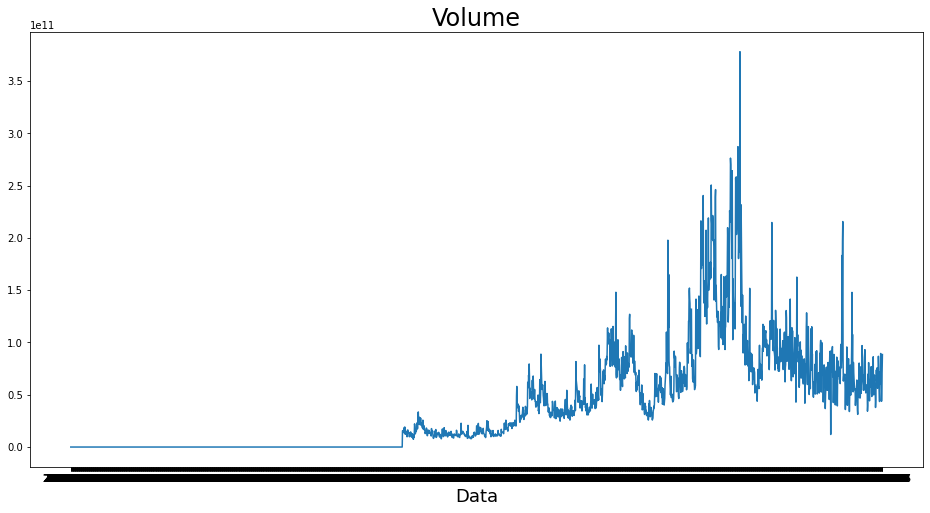

In [5]:
plt.figure(figsize=(16,8))
plt.title('Volume', fontsize=24)
plt.plot(df['Volume'])
plt.xlabel('Data', fontsize=18)
plt.show()

In [6]:
# exclude periods that valume=0
df=df[df['Volume']>0]
print(df.shape)
df

(1671, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2018-03-01,10214.10,10885.90,10052.20,10656.90,1.556998e+10
2018-03-02,10659.00,10887.70,10284.20,10512.20,1.572008e+10
2018-03-03,10509.10,10844.10,10306.30,10516.90,1.424458e+10
2018-03-04,10511.30,10803.00,10198.60,10689.10,1.378689e+10
2018-03-05,10694.30,10941.70,10407.40,10523.00,1.565674e+10
...,...,...,...,...,...
2022-09-23,7436.16,7704.71,7154.14,7509.82,6.951557e+10
2022-09-24,7509.82,7647.16,7332.20,7386.42,4.381290e+10
2022-09-25,7386.23,7546.36,7220.37,7308.52,6.020709e+10


In [7]:
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(df.shape[0] * .8) # We are using %80 of the data for training
training_data_len

1337

In [8]:
# Scale the data with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)
print(scaled_data)

[[0.26718113 0.27445008 0.28023588 0.28102918 0.02205259]
 [0.28119915 0.27450425 0.28790962 0.27647164 0.0224575 ]
 [0.27647607 0.27319202 0.28864061 0.27661967 0.0184771 ]
 ...
 [0.1780799  0.17394014 0.1865689  0.1755669  0.14246886]
 [0.17565881 0.17172591 0.18492698 0.17792063 0.18543182]
 [0.17798979 0.17932419 0.18556866 0.17544186 0.21862971]]


In [43]:
# hyper param
timeStep=60
batch_size=1
epochs=20
d=0.2

In [15]:

# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]

#Split the data into X_train and y_train data sets
X_train = np.array([train_data[i-timeStep:i,:] for i in range(timeStep, len(train_data))])
y_train = np.array([train_data[i,:] for i in range(timeStep, len(train_data))])
print(f'X_train shape:{X_train.shape}',f'y_train_shape: {y_train.shape}')

X_train shape:(1277, 60, 5) y_train_shape: (1277, 5)


In [23]:
# Create the testing dataset
# Create a new array containing scaled values from index 1335
test_data = scaled_data[training_data_len - timeStep : , :]
test_data
X_test = np.array([test_data[i-timeStep: i,:] for i in range(timeStep,len(test_data))])
y_test = np.array([test_data[i,:] for i in range(timeStep, len(test_data))])
print(f'X_test shape:{X_test.shape}',f'y_test_shape: {y_test.shape}')

X_test shape:(334, 60, 5) y_test_shape: (334, 5)


In [24]:
# Build LSTM model
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(128, return_sequences=True, input_shape=(timeStep, X_train.shape[-1])))
model_1.add(Dropout(d))
model_1.add(LSTM(128, return_sequences=False))
model_1.add(Dropout(d))
model_1.add(Dense(32))
model_1.add(Dense(5))

In [39]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           68608     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 204,485
Trainable params: 204,485
Non-trai

In [45]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(X_test,y_test))

Epoch 1/20
1277/1277 - 16s - loss: 0.0019 - val_loss: 0.0088 - 16s/epoch - 12ms/step
Epoch 2/20
1277/1277 - 13s - loss: 0.0016 - val_loss: 9.8306e-04 - 13s/epoch - 10ms/step
Epoch 3/20
1277/1277 - 13s - loss: 0.0013 - val_loss: 0.0016 - 13s/epoch - 10ms/step
Epoch 4/20
1277/1277 - 13s - loss: 0.0014 - val_loss: 0.0011 - 13s/epoch - 10ms/step
Epoch 5/20
1277/1277 - 14s - loss: 0.0015 - val_loss: 0.0016 - 14s/epoch - 11ms/step
Epoch 6/20
1277/1277 - 13s - loss: 0.0013 - val_loss: 0.0012 - 13s/epoch - 10ms/step
Epoch 7/20
1277/1277 - 13s - loss: 0.0016 - val_loss: 0.0012 - 13s/epoch - 10ms/step
Epoch 8/20
1277/1277 - 13s - loss: 0.0015 - val_loss: 0.0014 - 13s/epoch - 10ms/step
Epoch 9/20
1277/1277 - 13s - loss: 0.0013 - val_loss: 0.0017 - 13s/epoch - 10ms/step
Epoch 10/20
1277/1277 - 13s - loss: 0.0013 - val_loss: 0.0011 - 13s/epoch - 10ms/step
Epoch 11/20
1277/1277 - 13s - loss: 0.0014 - val_loss: 0.0035 - 13s/epoch - 10ms/step
Epoch 12/20
1277/1277 - 13s - loss: 0.0013 - val_loss: 9.40

<function matplotlib.pyplot.show(*args, **kw)>

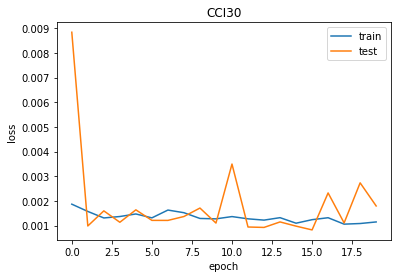

In [46]:
# plot the loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('CCI30',fontsize='12')
plt.ylabel('loss',fontsize='10')
plt.xlabel('epoch',fontsize='10')
plt.legend()
plt.show

In [47]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
predictions_1[:5,:]

array([[2.5071646e+04, 2.6290135e+04, 2.3771578e+04, 2.4331879e+04,
        1.5329793e+11],
       [2.6355166e+04, 2.7324695e+04, 2.5265654e+04, 2.5456158e+04,
        1.3644897e+11],
       [2.5997777e+04, 2.6991654e+04, 2.4837000e+04, 2.5101650e+04,
        1.3331149e+11],
       [2.5619617e+04, 2.6693080e+04, 2.4392623e+04, 2.4772342e+04,
        1.3801887e+11],
       [2.6269861e+04, 2.7274309e+04, 2.5120254e+04, 2.5372266e+04,
        1.3486851e+11]], dtype=float32)

In [73]:
#plotting param
dic={0:"Open",1:"High",2:"Low",3:"Close",4:"Volume"}
nums=0

In [77]:
# measure
from sklearn.metrics import mean_squared_error, r2_score
y_inver=scaler.inverse_transform(y_test)
for i in dic.keys():
  MAE=mean_squared_error(predictions_1[i], y_inver[i])
  R2=r2_score(predictions_1[i], y_inver[i])
  print(f'{dic[i]}: Mean Absolute Error={MAE} , | R2={R2}')
MAE=mean_squared_error(predictions_1, y_inver)
R2=r2_score(predictions_1, y_inver)
print(f'Total: Mean Absolute Error={MAE} , | R2={R2}')

Open: Mean Absolute Error=9.024412628827446e+20 , | R2=0.7599915316623946
High: Mean Absolute Error=5.924304354653003e+20 , | R2=0.80112644862469
Low: Mean Absolute Error=4.137422937341614e+20 , | R2=0.8544959969046242
Close: Mean Absolute Error=4.637659884797474e+20 , | R2=0.8478394038808836
Volume: Mean Absolute Error=2.2365096609759448e+20 , | R2=0.9231524813925807
Total: Mean Absolute Error=2.1031084060452526e+20 , | R2=0.6026087853860261


Text(0.5, 0, 'epochs')

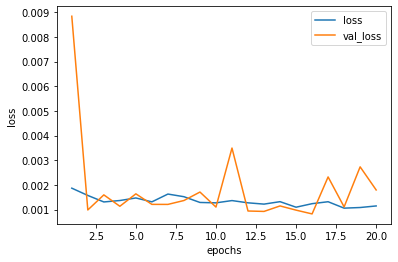

In [70]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [ ]:
# reference
# https://github.com/Ali619/Bitcoin-Price-Prediction-LSTM/blob/master/Bitcoin_Price_Prediction.ipynbb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


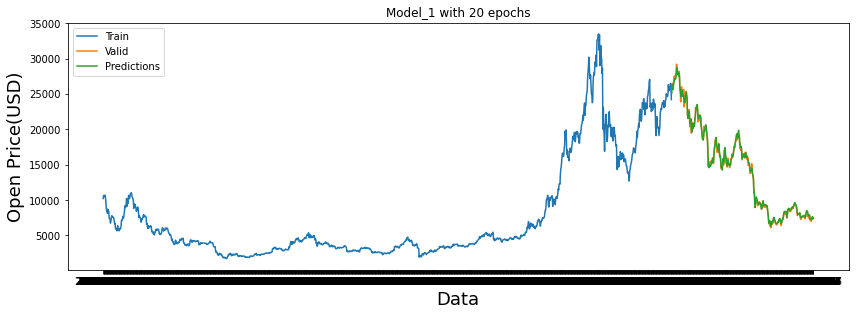

In [61]:
# Plot the data
train = df.iloc[:training_data_len]
# data for model_1
valid_1 = df.iloc[training_data_len:,:]
valid_1['Predictions'] = predictions_1[:,nums]

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title(f'Model_1 with {epochs} epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel(f'{dic[nums] if nums==4 else dic[nums]+" Price(USD)"}', fontsize=18)
plt.plot(train[dic[nums]])
plt.plot(valid_1[[dic[nums],"Predictions"]])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

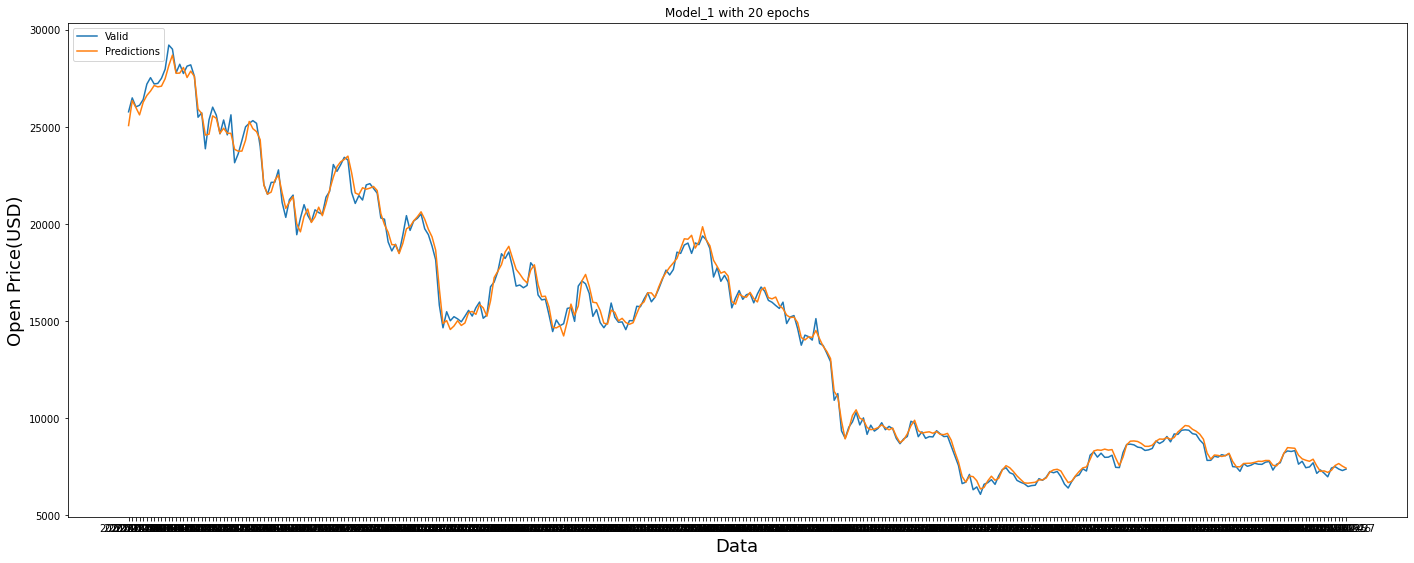

In [62]:
plt.figure(figsize=(24, 20))
plt.subplot(2, 1, 1)
plt.title(f'Model_1 with {epochs} epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel(f'{dic[nums] if nums==4 else dic[nums]+" Price(USD)"}', fontsize=18)
plt.plot(valid_1[[dic[nums],"Predictions"]])
plt.legend(['Valid', 'Predictions'], loc='upper left')

In [ ]:
 model_1.save('models/bdse27_lstm_model.h5')